# Protein art with hyperdimensional computing

1. Hundred protein sequences are randomly or non-randomy selected and embedded in hyperdimensional space
2. The vectors are projected in 2D (e.g. using a PCA)
3. Their 2D coordinates are transformed into polar coordinates
4. Each vector is plotted one by one. To start, one vector is chosen at random and the next one is always chosen based on the highest cosine similarity of the last one. This first one will also define what color each of the vectors are plotted in.
5. Color: a colormap is chosen and the width of the colormap is defined based on how far apart the sequences are in hyperdimensional space (very alike sequences will all have similar colors). 
6. Thickness: each vector is represented in polar coordinates by a line, and the line has a specific thickness. The thickness is defined by the distance to the randomly chosen first sequence (the fartest will have the smallest thickness).

Inspiration:
- https://plotly.com/julia/polar-chart/
- https://juliagraphics.github.io/ColorSchemes.jl/stable/basics/#Pre-defined-schemes-1

## 0 - Libraries and directories

In [8]:
push!(LOAD_PATH, "/Users/dimi/Documents/GitHub/HyperdimensionalComputing.jl/src/")
using HyperdimensionalComputing
using LinearAlgebra
using DataFrames
using ProgressMeter
using CSV
using JSON
using FASTX
using BioAlignments
using Random
using Plots
using StatsBase
using MultivariateStats
using Statistics
using MLJ
using DelimitedFiles
using BioAlignments
using ProgressMeter
using ScikitLearn
#using Pluto

"Valencia"

## 1 - Functions<a name="functions"></a>

In [9]:
function random_protein(length)
    """
    This function returns a random protein sequence of given length.
    """
    return Random.randstring("GAVLIFPSTYCMKRHWDENQX", length)
end

random_protein (generic function with 1 method)

In [27]:
function list_of_random_proteins(number)
    """
    This function creates a given number of random protein sequences 
    and puts them in a list. The lengths of the protein sequences
    are random between 30 and 800.
    """
    return [random_protein(rand(30:800)) for i in 1:number]
end

list_of_random_proteins (generic function with 1 method)

In [29]:
function embed_protein_sequence(sequence)
    """
    This function embeds a protein sequence into hyperdimensional space.
    """
    # define protein alphabet
    alphabet = "GAVLIFPSTYCMKRHWDENQX"
    basis = Dict(c=>BipolarHDV() for c in alphabet)
    
    # compute embedding
    embedding = sequence_embedding(string(sequence), basis, 3)
    return embedding
end 

embed_protein_sequence (generic function with 1 method)

In [31]:
function embed_sequences(sequences)
    """
    This function embeds proteins in a list and returns a hyperdimensional array.
    """
    embeddings = Array{BipolarHDV}(undef, length(sequences))
    for (i, sequence) in enumerate(sequences)
        embeddings[i] = embed_protein_sequence(sequence)
    end
    return embeddings
end

embed_sequences (generic function with 1 method)

In [41]:
function reduce_embeddings(embeddings)
    """
    This function reduces embeddings from hyperdimensional space into two dimensions with PCA.
    """
    # flip the embeddings for PCA
    embeddings_flipped = zeros(Int64, 10000, size(embeddings)[1])
    for i in 1:size(embeddings)[1]
        embeddings_flipped[:,i] = embeddings[i]
    end

    # compute the PCA
    pca = fit(PCA, embeddings_flipped, pratio=1, maxoutdim=2)
    
    # compute reduced embeddings
    reduced_embeddings = MultivariateStats.transform(pca, embeddings_flipped)
    return reduced_embeddings
end

reduce_embeddings (generic function with 1 method)

In [43]:
function cart2pol(x,y)
    """
    This function translates cartesian coordinates to polar coordinates.
    """
    rad, theta = sqrt(x^2 + y^2), atan(y, x)
    return rad, theta
end

cart2pol (generic function with 1 method)

In [107]:
function plot_reduced(reduced_embeddings)
    """
    This function plots the reduced embeddings (based on specified rules)
    """
    # shuffle the embeddings (random one to start plotting)
    reduced_shuffled = reduced_embeddings[:, shuffle(1:end)]

    
    # transform to polar coords
    rads = [cart2pol(reduced_embeddings[1, i], reduced_embeddings[2,i])[1] for i in 1:size(reduced_embeddings)[2]]
    thetas = [cart2pol(reduced_embeddings[1, i], reduced_embeddings[2,i])[2] for i in 1:size(reduced_embeddings)[2]]
    
    # establish plot
    fig = plot(proj=:polar, ticks=false, showaxis=false, legend=false)
    
    # plot all the lines
    for i in 1:length(rads)
        plot!([0, thetas[i]], [0, rads[i]], lw=rand(1:6))
    end
    display(fig)
end

plot_reduced (generic function with 1 method)

In [119]:
function generative_hdc_random_proteins()
    """
    Make generative HDC art for 100 random proteins
    """
    sequences = list_of_random_proteins(100)
    embeddings = embed_sequences(sequences)
    reduced_embeddings = reduce_embeddings(embeddings)
    plot_reduced(reduced_embeddings)
end

generative_hdc_random_proteins (generic function with 1 method)

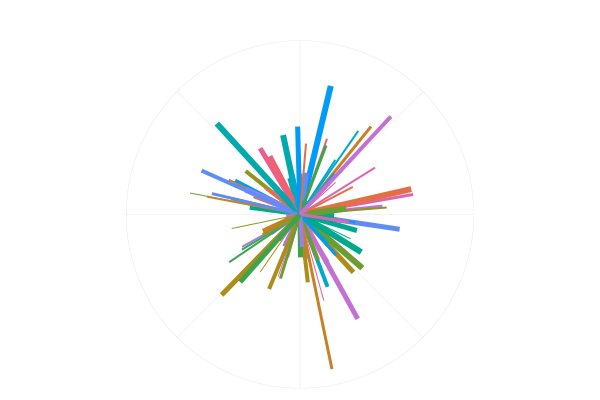

In [143]:
generative_hdc_random_proteins()

## 2 - Generating plots<a name="plots"></a>

In [95]:
using ColorSchemes
ColorSchemes.leonardo
get(leonardo, 0.5) # sample anywhere between 0 and 1

LoadError: ArgumentError: Package ColorSchemes not found in current path:
- Run `import Pkg; Pkg.add("ColorSchemes")` to install the ColorSchemes package.


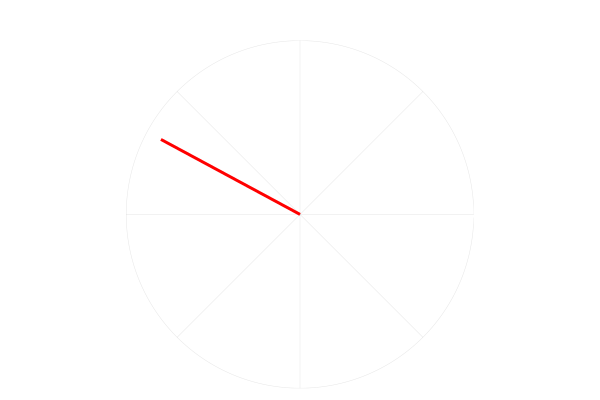

In [80]:
plot([0, th],[0, r], proj=:polar, lw=3, ticks=false, showaxis=false, legend=false, linecolor=:red)
#plot!([0], [0], m=:red)

In [ ]:
plot(thetas, rs, proj=:polar)

In [7]:
# compute loci embeddings w/ proteins (multi-instance)
loci_embeddings = Array{BipolarHDV}(undef, length(LociBase))
for (i, (name, proteins)) in enumerate(LociBase)
    # bind within one sequence, then aggregate the different sequences
    protein_hdvs = [sequence_embedding(string(sequence), basis, 3) for sequence in proteins]
    loci_hdv = HyperdimensionalComputing.aggregate(protein_hdvs)
    loci_embeddings[i] = loci_hdv
end

In [9]:
# compute the rbp-receptor signatures (bind operation)
signatures_pos = Dict()
signatures_neg = Dict()
for (i, loci_embedding) in enumerate(loci_embeddings)
    for (j, rbp_embedding) in enumerate(rbp_embeddings)
        if isequal(interaction_matrix[i,j], 1)
            signatures_pos[(i,j)] = HyperdimensionalComputing.bind([loci_embedding, rbp_embedding])
        elseif isequal(interaction_matrix[i,j], 0)
            signatures_neg[(i,j)] = HyperdimensionalComputing.bind([loci_embedding, rbp_embedding])
        end
    end
end
#signatures_pos = convert(Array{BipolarHDV}, signatures_pos)
#signatures_neg = convert(Array{BipolarHDV}, signatures_neg)
println("pos: ", length(signatures_pos), " neg: ", length(signatures_neg))

pos: 29 neg: 1211


#### PCA of the RBP embeddings

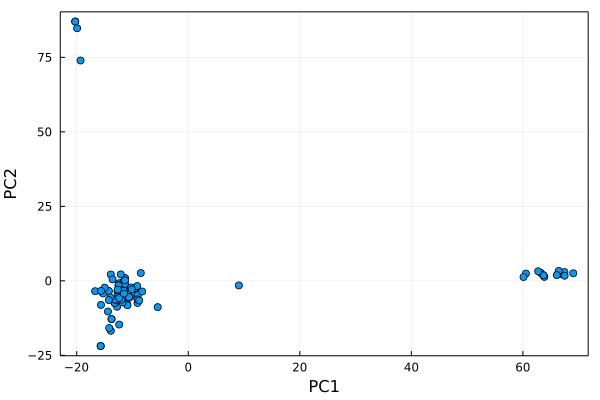

In [10]:
# flip the embeddings for PCA
rbp_embeddings_flipped = zeros(Int64, 10000, length(RBPbase.ProteinSeq))
for i in range(1, length=length(RBPbase.ProteinSeq))
    rbp_embeddings_flipped[:,i] = rbp_embeddings[i]
end

# compute the PCA
pca = fit(PCA, rbp_embeddings_flipped, pratio=1, maxoutdim=4)
proj = projection(pca) # each column is a principal component
percent_total_variance = principalvars(pca) ./ tvar(pca) * 100

# visualize
rbp_transformed = MultivariateStats.transform(pca, rbp_embeddings_flipped)
h = plot(rbp_transformed[1,:], rbp_transformed[2,:], seriestype=:scatter, label="")
plot!(xlabel="PC1", ylabel="PC2", framestyle=:box)

#### PCA of the signatures colored by RBP

In [21]:
savefig(h, results_dir*"/HDC_scatter_locibind_cosine_alignment.png")